# Chapter 10: Reality Check

## COVID-19 Nursing Homes

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats

In [2]:
def p_2tail(sampdist,tstat):
    hyp = np.mean(sampdist)
    cutoff1 = hyp - np.abs(hyp - tstat)
    cutoff2 = hyp + np.abs(hyp - tstat)
    
    points = sns.kdeplot(sampdist).get_lines()[0].get_data() # get x and y values from plot
    x = points[0]
    y = points[1]

    plt.fill_between(x,y, where = (x < cutoff1) | (x > cutoff2), color='r')
    plt.fill_between(x,y, where = (x >= cutoff1) & (x <= cutoff2), color='g')
    plt.show()
    
    pvalue = sum((sampdist < cutoff1) | (sampdist > cutoff2)) / len(sampdist)
    return pvalue

In [3]:
CA_COVID = pd.read_csv("../data/CA COVID.csv")
CA_COVID.head()

,County,FACILITY NAME,COUNTY,FACILITY ID,AVAILABLE BEDS,AVAILABLE BEDS CAPABLE OF ISOLATION,NEW CONFIRMED POSITIVE RESIDENTS,CURRENT ACTIVE CASES RESIDENTS,CUMULATIVE POSITIVE RESIDENTS,COVID-RELATED RESIDENT DEATHS,NEW CONFIRMED POSITIVE HCW,CURRENT ACTIVE HCW,CUMULATIVE POSITIVE HCW,COVID-RELATED HCW DEATHS
0,Alameda,ALAMEDA COUNTY MEDICAL CENTER D/P SNF,ALAMEDA,140000321,7,4,0,0,86,0,0,<11,76,0
1,Alameda,ALAMEDA HEALTHCARE & WELLNESS CENTER,ALAMEDA,20000043,54,8,0,0,88,<11,0,0,55,0
2,Alameda,ALAMEDA HOSPITAL - SOUTHSHORE CONVALESCENT,ALAMEDA,630011864,1,1,0,0,<11,0,0,0,<11,0
3,Alameda,ALAMEDA HOSPITAL D/P SNF,ALAMEDA,140000686,3,1,0,0,<11,0,0,0,13,0
4,Alameda,ALL SAINT'S MAUBERT,ALAMEDA,630013891,2,0,0,0,0,0,0,0,<11,0


In [4]:
CA_COVID.columns

Index(['County', 'FACILITY NAME', 'COUNTY', 'FACILITY ID', 'AVAILABLE BEDS',
       'AVAILABLE BEDS CAPABLE OF ISOLATION',
       'NEW CONFIRMED POSITIVE RESIDENTS ', 'CURRENT ACTIVE CASES RESIDENTS ',
       'CUMULATIVE POSITIVE RESIDENTS ', 'COVID-RELATED RESIDENT DEATHS',
       'NEW CONFIRMED POSITIVE HCW   ', 'CURRENT ACTIVE HCW',
       'CUMULATIVE POSITIVE HCW ', 'COVID-RELATED HCW DEATHS '],
      dtype='object')

In [5]:
size = CA_COVID['AVAILABLE BEDS']
patients_I = CA_COVID['CUMULATIVE POSITIVE RESIDENTS ']
patients_D = CA_COVID['COVID-RELATED RESIDENT DEATHS']
staff_I = CA_COVID['CUMULATIVE POSITIVE HCW ']
staff_D = CA_COVID['COVID-RELATED HCW DEATHS ']

df = pd.DataFrame(data = {'size':size, 'patients_I':patients_I, 'staff_I':staff_I, 'patients_D':patients_D, 'staff_D':staff_D})
df.head()

,size,patients_I,staff_I,patients_D,staff_D
0,7,86,76,0,0
1,54,88,55,<11,0
2,1,<11,<11,0,0
3,3,<11,13,0,0
4,2,0,<11,0,0


## Staff Infections and Deaths

In [6]:
df['staff_D'].value_counts()

0      1057
<11     166
Name: staff_D, dtype: int64

In [7]:
len(df[df['staff_I'] != "0"])

1201

***prop test: how likely infections across the staff, null hypothesis 15%***

In [8]:
scipy.stats.chisquare([166, 1201-166], [0.15*1201, 0.85*1201])

Power_divergenceResult(statistic=1.3075541623810225, pvalue=0.25283796546318715)

In [9]:
df1 = df[staff_I != "0"]
staff_D_1 = np.where(df1['staff_D'] == "0", "none", "some")
staff_I_1 = np.where(df1['staff_I'] == "<11", "small", "large")

***chi square contingency table***

In [10]:
no_d_large_inf = ((staff_D_1 == 'none') & (staff_I_1 == 'large')).sum()
no_d_small_inf = ((staff_D_1 == 'none') & (staff_I_1 == 'small')).sum()
some_d_small_inf = ((staff_D_1 == 'some') & (staff_I_1 == 'small')).sum()
some_d_large_inf = ((staff_D_1 == 'some') & (staff_I_1 == 'large')).sum()
test_arr =np.array( [[no_d_large_inf, no_d_small_inf], [some_d_large_inf, some_d_small_inf]])
scipy.stats.chi2_contingency(test_arr)

(4.148092869278095,
 0.041681444354659966,
 1,
 array([[1007.42298085,   27.57701915],
        [ 161.57701915,    4.42298085]]))

In [11]:
staff_I_2 = np.where(df1['staff_I'] == "<11", 5, df1['staff_I'])
staff_I_2 = staff_I_2.astype(int)
pd.DataFrame(staff_D_1).value_counts()

none    1035
some     166
dtype: int64

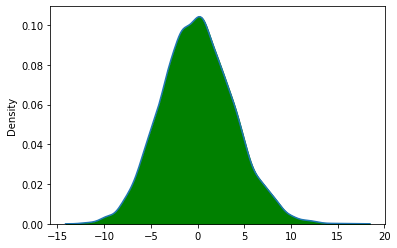

0.0

In [12]:
np.random.seed(87654321)
def f1():
    s1 = np.random.choice(staff_I_2, size=len(staff_I_2))
    control1 = s1[:1035]
    treatment = s1[1035:]
    return(np.mean(treatment)-np.mean(control1))
sampdist = [f1() for _ in range(10000)]
t1 = np.mean(staff_I_2[staff_D_1 == "none"])
t2 = np.mean(staff_I_2[staff_D_1 == "some"])
tstat = t2 - t1
p_2tail(sampdist, tstat)

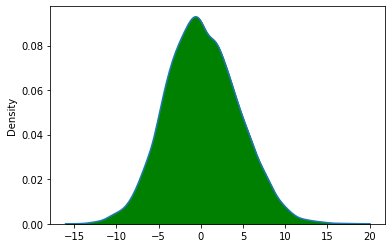

0.0

In [13]:
np.random.seed(87654321)
def f1():
    s1 = np.random.choice(staff_I_2, size=len(staff_I_2))
    control1 = s1[:1035]
    treatment = s1[1035:]
    return(np.median(treatment)-np.median(control1))
sampdist = [f1() for _ in range(10000)]
t1 = np.median(staff_I_2[staff_D_1 == "none"])
t2 = np.median(staff_I_2[staff_D_1 == "some"])
tstat = t2 - t1
p_2tail(sampdist, tstat)

## Patient and Staff Infections